In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# Load the data from the CSV file into a DataFrame
data = pd.read_csv('data_clustering.csv', header=None) 

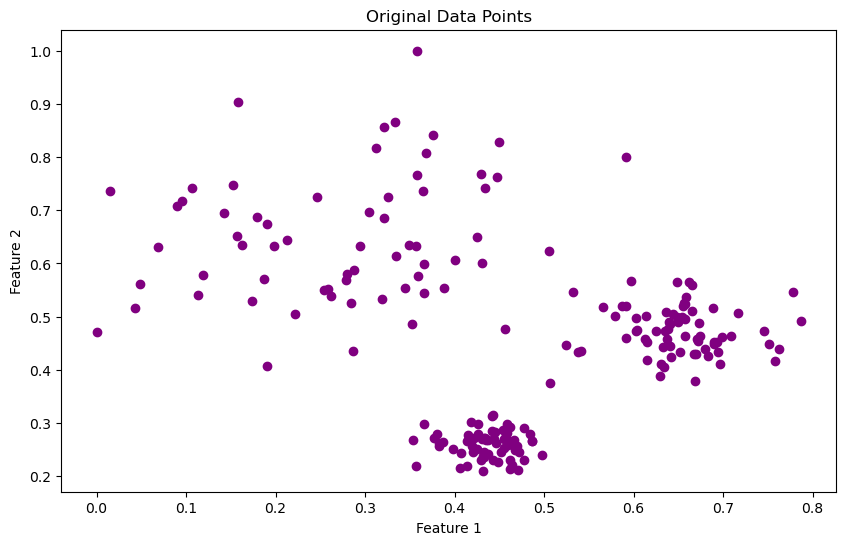

In [12]:
# Visualization of original data points
plt.figure(figsize=(10, 6))
plt.scatter(data[0], data[1], color='purple')
plt.title('Original Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [13]:
def DBSCAN (D, eps, MinPts):
    C = 0 #cluster_id
    labels = np.zeros(len(D), dtype = int)  # Initialize cluster labels
    
    # for each unvisited point P in dataset D
    for P in range (len(D)): 
        if labels[P] == 0: # unvisited points
            NeighborPts_indices = regionQuery(D, P, eps) # Get neighbors
            if len(NeighborPts_indices) < MinPts: 
                labels[P] = -1 # mark P as noise
            else:
                C += 1
                expandCluster(P, NeighborPts_indices, C, eps, MinPts, D, labels)
    return labels

def expandCluster (P, NeighborPts_indices, C, eps, MinPts, D, labels):
    labels[P] = C
    
    for j in NeighborPts_indices:
        if labels[j] == 0:
            labels[j] = C
            new_NeighborPts = regionQuery (D,j,eps)
            if len(new_NeighborPts) >= MinPts:
                NeighborPts_indices.extend(new_NeighborPts)
    
        if labels[j] == -1:
            labels[j] = C
            
def regionQuery(D, P, eps):
    point = D[P]  # Get the point at index P
    distances = np.sqrt(np.sum((D - point) ** 2, axis=1))  
    neighbor_indices = np.where(distances <= eps)[0]  
    return neighbor_indices.tolist()  


Optimal eps for k=3: 0.05469461621418371
Optimal eps for k=4: 0.07491615431308885
Optimal eps for k=5: 0.07221661751650989


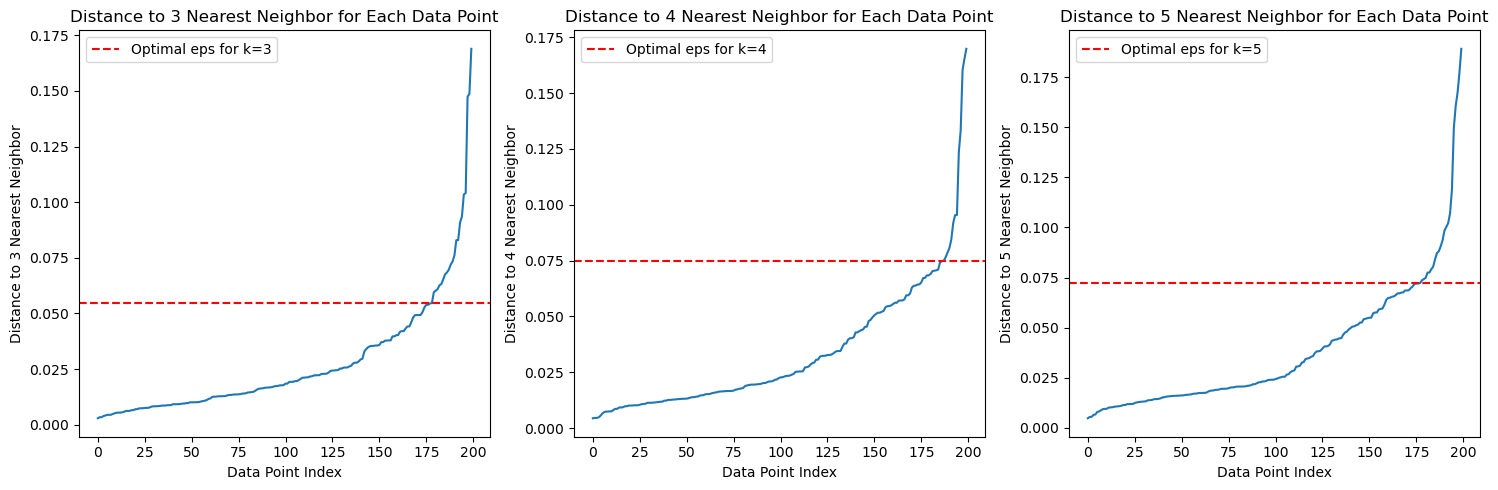

In [14]:
# Set k values (number of nearest neighbors)
k_values = [3, 4, 5]

# Create subplots for each k value
fig, axs = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    # Fit Nearest Neighbors model
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)

    # Calculate distances to the k-th nearest neighbor for each data point
    distances, indices = neigh.kneighbors(data)
    distances_to_k_neighbor = np.sort(distances[:, -1])

    # Plot the distances
    axs[i].plot(distances_to_k_neighbor)
    
    # Find the knee/elbow point
    knee = KneeLocator(range(len(distances_to_k_neighbor)), distances_to_k_neighbor,
                        curve='convex', direction='increasing')

    # Plot the elbow point
    optimal_eps = distances_to_k_neighbor[knee.knee]
    axs[i].axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps for k={k}')

    axs[i].set_xlabel('Data Point Index')
    axs[i].set_ylabel(f'Distance to {k} Nearest Neighbor')
    axs[i].set_title(f'Distance to {k} Nearest Neighbor for Each Data Point')
    axs[i].legend()
    
    optimal_eps = distances_to_k_neighbor[knee.knee]
    print(f'Optimal eps for k={k}: {optimal_eps}')
    
plt.tight_layout()
plt.show()


We chose eps = 0.07221661751650989, taking the median of the obtained values.

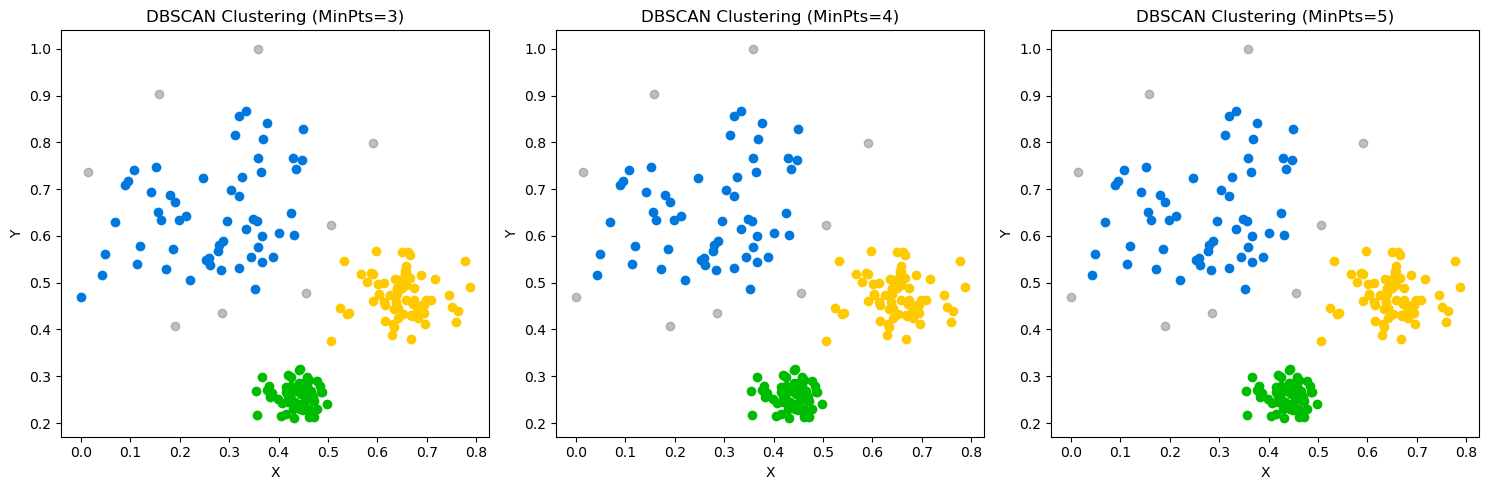

Average Silhouette Score for MinPts=3: 0.6033790917906567
Average Silhouette Score for MinPts=4: 0.6056528761570885
Average Silhouette Score for MinPts=5: 0.6056528761570885


In [15]:
t = 0.07221661751650989
Min_Pts=[3,4,5]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Counter to keep track of the index
counter = 0

silhouette_scores = []

# Iterate through k values
for MinPts in Min_Pts:
    cluster_labels = DBSCAN(data.values, t, MinPts)

    # Plot the points color-coded by cluster index
    for j in range(len(data)):
        if cluster_labels[j] == -1:
            axs[counter].scatter(data.iloc[j, 0], data.iloc[j, 1], color='gray', alpha=0.5, label='Noise')
        else:
            axs[counter].scatter(data.iloc[j, 0], data.iloc[j, 1], color=plt.cm.nipy_spectral(cluster_labels[j] / len(np.unique(cluster_labels))))

    axs[counter].set_xlabel('X')
    axs[counter].set_ylabel('Y')
    axs[counter].set_title(f'DBSCAN Clustering (MinPts={MinPts})')
    
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Increment the counter for the next subplot
    counter += 1

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

for i in range(len(Min_Pts)):
    MinPts = Min_Pts[i]
    silhouette_avg = silhouette_scores[i]
    print(f'Average Silhouette Score for MinPts={MinPts}: {silhouette_avg}')

# BONUS

In [16]:
! pip install scipy
import scipy.io

In [17]:
# functions to help us compare the end result with the ground truth

def matching_elements(list1, list2):
    count = sum(1 for i in range(len(list1)) if list1[i] == list2[i])
    return count

def calculate_precision_recall_fscore(truth, sample):
    
    true_positives = sum(1 for i in range(len(truth)) if truth[i] == sample[i] == 1 or truth[i] == sample[i] == 0)
    false_positives = sum(1 for i in range(len(truth)) if truth[i] == 0 and sample[i] == 1)
    false_negatives = sum(1 for i in range(len(truth)) if truth[i] == 1 and sample[i] == 0)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
    f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f_score

In [18]:
thyroid_data = scipy.io.loadmat(r"thyroid.mat")
datapoints = thyroid_data['X']
ground_truth = thyroid_data['y']

print ("Datapoints shape: ",datapoints.shape)
ground_truth = ground_truth.reshape(-1) 
print("Ground_truth shape: ", ground_truth.shape)

Datapoints shape:  (3772, 6)
Ground_truth shape:  (3772,)


Optimal eps for k=60: 0.2576152269633468
Optimal eps for k=61: 0.28142354807250736
Optimal eps for k=62: 0.28129265996207903


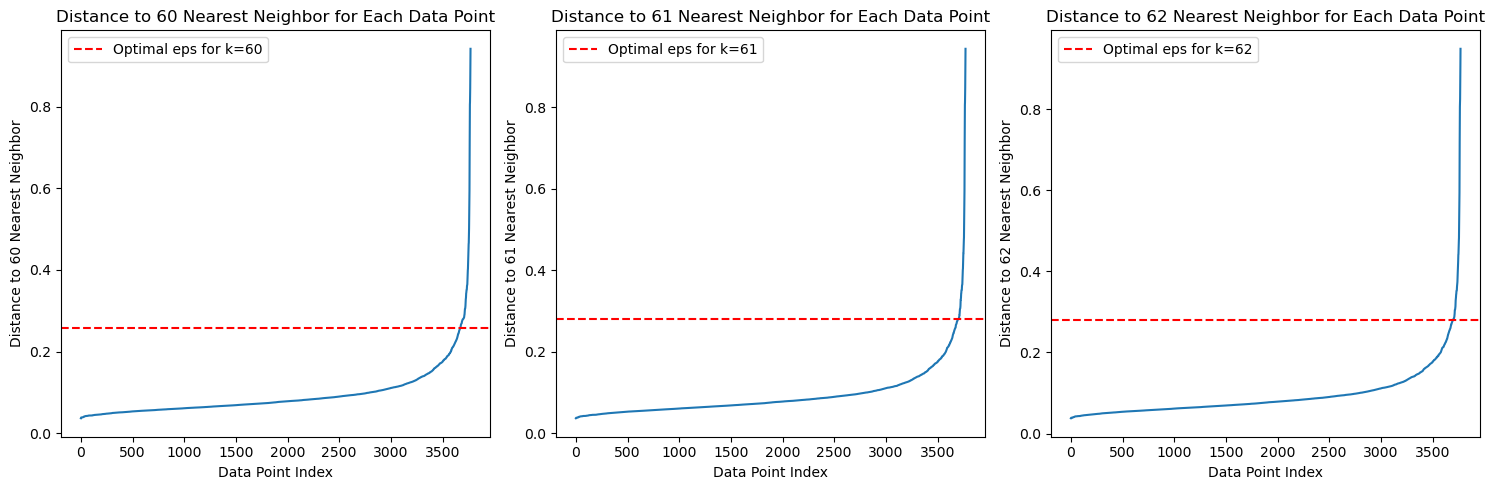

In [19]:
# Finding optimal eps

k_values = [60,61,62]

# Create subplots for each k value
fig, axs = plt.subplots(1, len(k_values), figsize=(15, 5))

for i, k in enumerate(k_values):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(datapoints)

    # Calculate distances to the k-th nearest neighbor for each data point
    distances, indices = neigh.kneighbors(datapoints)
    distances_to_k_neighbor = np.sort(distances[:, -1])

    axs[i].plot(distances_to_k_neighbor)
    
    # Find the knee point
    knee = KneeLocator(range(len(distances_to_k_neighbor)), distances_to_k_neighbor,
                        curve='convex', direction='increasing')

    # Plot the knee point
    optimal_eps = distances_to_k_neighbor[knee.knee]
    axs[i].axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps for k={k}')

    axs[i].set_xlabel('Data Point Index')
    axs[i].set_ylabel(f'Distance to {k} Nearest Neighbor')
    axs[i].set_title(f'Distance to {k} Nearest Neighbor for Each Data Point')
    axs[i].legend()
    
    optimal_eps = distances_to_k_neighbor[knee.knee]
    print(f'Optimal eps for k={k}: {optimal_eps}')
    
plt.tight_layout()
plt.show()

We chose eps = 0.28129265996207903, taking the median of the obtained values.

In [20]:
t = 0.28129265996207903
    
for MinPts in [10,12,14]: 
    cluster_labels = DBSCAN(datapoints, t, MinPts)

    # Modify the labels i.e. 1 = outliers, 0 = inliers
    cluster_labels[cluster_labels > 0] = 0
    cluster_labels[cluster_labels == -1] = 1 # Change -1 to 1 (noise)

    matching_count = matching_elements(cluster_labels, ground_truth)
    print(f"Number of matching elements when MinPts={MinPts}:", matching_count)
    
    precision, recall, f_score = calculate_precision_recall_fscore(cluster_labels, ground_truth)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F-score:", f_score)
    print()
        


Number of matching elements when MinPts=10: 3678
Precision: 0.9768924302788845
Recall: 0.998100407055631
F-score: 0.9873825503355705

Number of matching elements when MinPts=12: 3678
Precision: 0.9768924302788845
Recall: 0.998100407055631
F-score: 0.9873825503355705

Number of matching elements when MinPts=14: 3677
Precision: 0.9768862911795961
Recall: 0.9978290366350068
F-score: 0.9872466102832596

